In [1]:
import tensorflow as tf
from tqdm import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pandas as pd
import string

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
      PATH = os.path.abspath('.') + image_folder

In [59]:
# Read the json file

annotation_file ='./annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + ' '.join((annot['caption'].translate(str.maketrans('', '', string.punctuation))).split(' ')[:25]) + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state


# Select the first 30000 captions from the shuffled set
#num_examples = 30000
#train_captions = train_captions[:num_examples]
#img_name_vector = img_name_vector[:num_examples]

print(len(all_img_name_vector))
print(len(all_captions))
print(f' max len for captions {max(len(t.split(" ")) for t in all_captions)}')
print(f' min len for captions {min(len(t.split(" ")) for t in all_captions)}')

414113
414113
 max len for captions 27
 min len for captions 10


In [198]:
### ADD EXTRA DISNEY
### CHECK FOR NOT JPEG FILES

not_jpg = []

disney_words = []
disney_captions = []
disney_images = []

disney=pd.read_csv('how_to.csv').to_dict(orient='records')
files = frozenset(os.listdir('./disney_img/'))
for item in tqdm(disney):
    file_name = item['im_id']
    if ('jpg' in file_name) and (file_name in files):
        try:
            caption = ' '.join((item['title'].translate(str.maketrans('', '', string.punctuation))).split(' ')[:25])
            caption  = '<start> ' + caption + ' <end>'
            if len(caption.split(' ')) < 5:
                continue
            file_path = './disney_img/'+item['im_id']
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            all_img_name_vector.append(file_path)
            all_captions.append(caption)
            disney_words+=[w.lower() for w in caption.split(' ')]
            disney_captions.append(caption)
            disney_images.append(file_path)
        except:
            not_jpg.append(file_path)
     
    
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)
            
print(len(all_captions))
print(len(img_name_vector))
print(f' max len for captions {max(len(t.split(" ")) for t in train_captions)}')
print(f' min len for captions {min(len(t.split(" ")) for t in train_captions)}')

100%|██████████| 27775/27775 [00:34<00:00, 794.32it/s] 


449993
449993
 max len for captions 27
 min len for captions 5


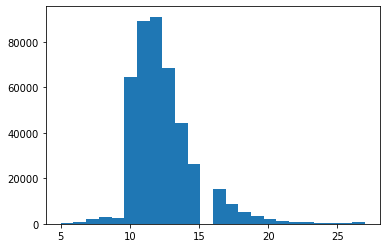

In [69]:
plt.hist([len(t.split(" ")) for t in all_captions],bins=24);

In [93]:
def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path

#### DEFINE FEATURE EXTRACTOR ON Inception3

In [91]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

### SAVE FEATURE VECTORS

In [94]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))  # reshapa from  [32, 8, 8, 2048] to [32, 64, 2048]

    
    for bf, p in zip(batch_features, path):
        feature_name = p.numpy().decode("utf-8").split('/')[-1]
        feature_path = './features/'+feature_name
        np.save(feature_path, bf.numpy())

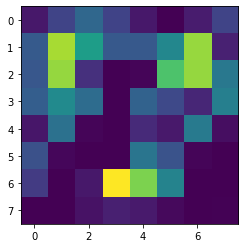

In [124]:
plt.imshow(batch_features.numpy()[0,:,:,3])

### FIND VOCABULARY SIZE

In [72]:
words = [w.lower() for s in train_captions for w in s.split(' ')]
print(f' vocab size: {len(set(words))}')
print(f' captions size: {len(all_captions) }')
print(f' min len for captions {min(len(t.split(" ")) for t in train_captions)}')
print(f' max len for captions {max(len(t.split(" ")) for t in train_captions)}')

 vocab size: 31794
 captions size: 432053
 min len for captions 5
 max len for captions 27


In [73]:
from collections import Counter
all_words_count = Counter(words)
disney_words_count = Counter(disney_words)

In [74]:
disney_words_count.most_common()[-10:]

[('lance', 1),
 ('jills', 1),
 ('cockney', 1),
 ('flashlight', 1),
 ('wisconsinite', 1),
 ('214', 1),
 ('“smart”', 1),
 ('cinderella', 1),
 ('concerns', 1),
 ('crucifiction', 1)]

In [75]:
all_words_count.most_common()[-10:]

[('ceviche', 1),
 ('crostini', 1),
 ('multiwired', 1),
 ('subdue', 1),
 ('hostpital', 1),
 ('xmas', 1),
 ('smirky', 1),
 ('midtrick', 1),
 ('remodeld', 1),
 ('transformers', 1)]

In [78]:
rare_words = []
for word in all_words_count.most_common()[::-1]:
    if word[1] < 4:
        rare_words.append(word)
        
print(f'Rare words: {len(rare_words)}')

Rare words: 19993


In [79]:
len(set(words)) - len(rare_words)

11801

### 10000 WORDS VOCAB

In [80]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [81]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [82]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [83]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
max_sent_len = 27
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sent_len)
print(f'captions vector shape {cap_vector.shape}')

captions vector shape (432053, 27)


In [84]:
len(img_name_vector)

432053

In [85]:
# Create training and validation sets using an 80-20 split

image_features =   ['./features/'+name.split('/')[-1] for name in img_name_vector]

img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_features,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(345642, 345642, 86411, 86411)

In [86]:
img_name_train[:1]

['./features/COCO_train2014_000000310203.jpg']

In [128]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [129]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [150]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
64 x 2048 

In [146]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [147]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [151]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [152]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [154]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [162]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f'load from {ckpt_manager.latest_checkpoint}')
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [161]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        ### CNN Encoder
        
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [163]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1000 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.0080
Epoch 1 Batch 1000 Loss 1.4143
Epoch 1 Batch 2000 Loss 1.3221
Epoch 1 Batch 3000 Loss 1.1865
Epoch 1 Batch 4000 Loss 1.2927
Epoch 1 Batch 5000 Loss 1.2066
Epoch 1 Loss 1.339386
Time taken for 1 epoch 334.94430708885193 sec

Epoch 2 Batch 0 Loss 1.2414
Epoch 2 Batch 1000 Loss 1.0533
Epoch 2 Batch 2000 Loss 1.1521
Epoch 2 Batch 3000 Loss 1.1236
Epoch 2 Batch 4000 Loss 1.1055
Epoch 2 Batch 5000 Loss 1.1428
Epoch 2 Loss 1.155965
Time taken for 1 epoch 312.27814173698425 sec

Epoch 3 Batch 0 Loss 1.1084
Epoch 3 Batch 1000 Loss 1.1031
Epoch 3 Batch 2000 Loss 1.0218
Epoch 3 Batch 3000 Loss 1.1184
Epoch 3 Batch 4000 Loss 1.0709
Epoch 3 Batch 5000 Loss 1.0161
Epoch 3 Loss 1.100545
Time taken for 1 epoch 312.8543059825897 sec

Epoch 4 Batch 0 Loss 1.1379
Epoch 4 Batch 1000 Loss 1.1049
Epoch 4 Batch 2000 Loss 1.0741
Epoch 4 Batch 3000 Loss 1.0821
Epoch 4 Batch 4000 Loss 1.0398
Epoch 4 Batch 5000 Loss 1.0987
Epoch 4 Loss 1.062813
Time taken for 1 epoch 318.8221900463104

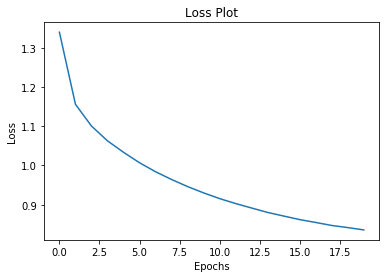

In [164]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### EVALUATE

In [192]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        ### Slighlty randomize prediction - can be changed to Beam Search ###
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(temp_image)

In [175]:
img_path_val = [im_path.replace('features','train2014')  for im_path in  img_name_val]

Real Caption: <start> a plate of food is sitting on the table next to a glass <end>
Prediction Caption: a sandwich and a gourmet pizza in a pizza with a salad on counter top <end>


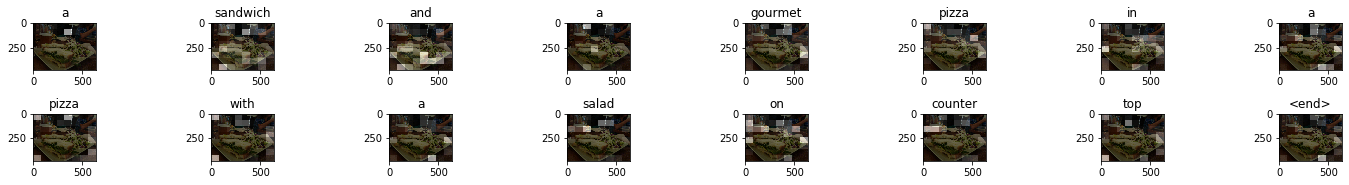

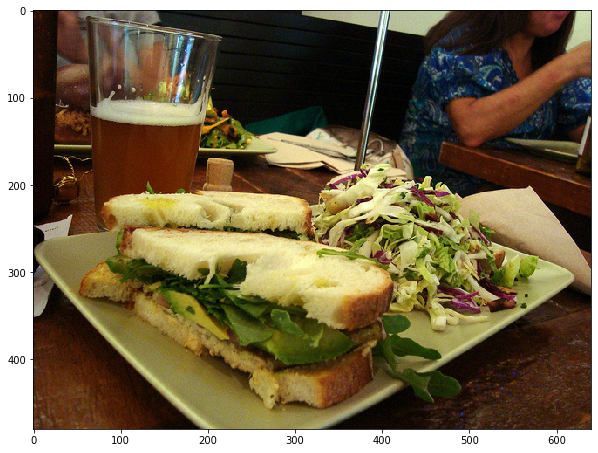

In [197]:
# captions on the validation set
max_length = 27
rid = np.random.randint(0, len(img_path_val))
image = img_path_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [200]:
disney_captions[rid]
#disney_images.append(file_path)

'<start> How to get rich off of your ridiculous pig ears <end>'

Real Caption: <start> How to stop getting erect in public <end>
Prediction Caption: how to impersonate your sexual favors <end>


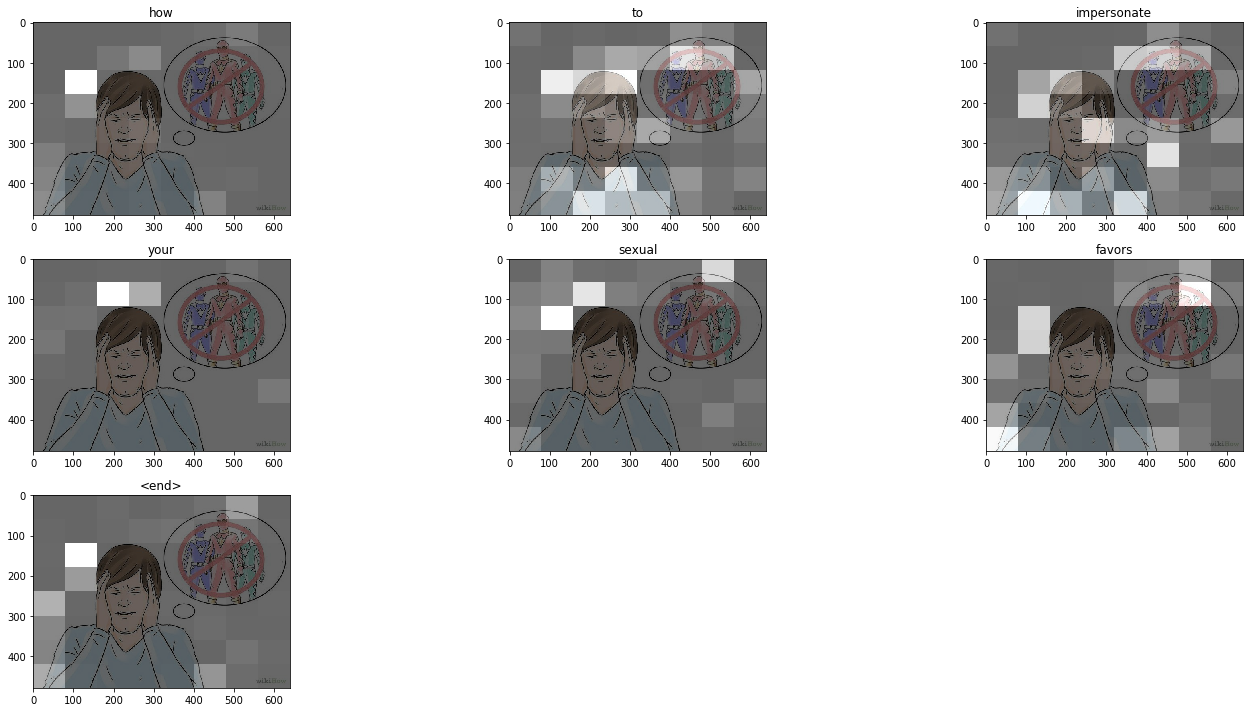

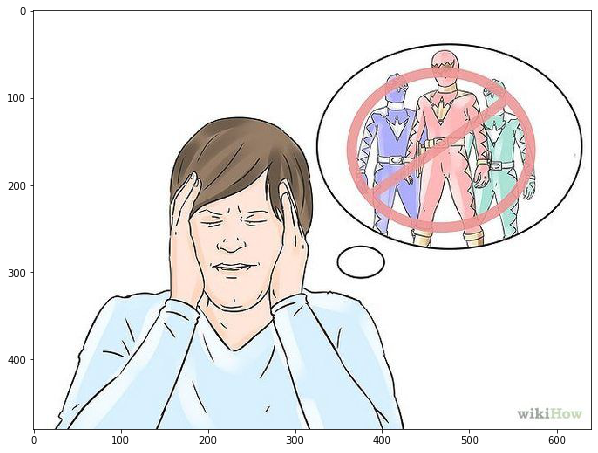

In [242]:
# captions on the validation set
max_length = 27
rid = np.random.randint(0, len(disney_images))
image = disney_images[rid]
real_caption = disney_captions[rid] 
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)